# DA 380: Sequential Analysis Project
### Author: Minh Le
### Dr. Wang

--- 
---

## I. Introduction

**Purpose:** This notebook builds a tidy time series dataset from the NOAA Tides and Currents API and applies sequential monitoring tools to the water level anomaly during the late January to early February 2024 storm window. The main signal is the smoothed anomaly, defined as observed water level minus predicted tide, which is meant to isolate storm driven forcing after removing the dominant tidal cycle.

**Data window and resolution:**
- Station: 9414290 (San Francisco, CA)
- Study period: 2024-01-29 to 2024-02-10
- Sampling: 6 minute interval

## II. Data Collection

1) Each product is downloaded separately and parsed into a dataframe with a common datetime column.
2) All products are merged on datetime, sorted, and indexed by datetime.
3) Missing values inside the series are filled using time based interpolation so the sequence stays continuous for control charts and change detection.
4) The anomaly is computed as: anomaly_m = water_level_m - predicted_tide_m
5) The anomaly is smoothed using a centered rolling mean with window = 10 observations, which is about 1 hour: anomaly_smooth = rolling mean of anomaly_m, window 10, centered

In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import seaborn as sns
import numpy as np
import math
from datetime import datetime, timedelta

# Select NOAA water level station and date range
STATION_ID = "9414290"       # San Francisco, CA
START_DATE = "20240129"      # YYYYMMDD
END_DATE   = "20240210"      # YYYYMMDD

# Define NOAA API parameters
BASE_URL = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
FILE_PATH = "./data/noaa_water_levels_dataset.csv"

In [ ]:
def fetch_noaa_data(station_id, start_date, end_date, product, params_extra={}):
    '''
    Fetch data from NOAA Tides and Currents API.
    Returns: pd.DataFrame with the requested data
    '''

    print(f"Fetching {product} data from {start_date} to {end_date} for station {station_id}...")
    # Build parameters for the API request
    params = {
        "begin_date": start_date,
        "end_date": end_date,
        "station": station_id,
        "product": product,
        "units": "metric",
        "time_zone": "gmt",
        "format": "json"
    }
    params.update(params_extra)
    
    response = requests.get(BASE_URL, params=params)
    data_json = response.json()
    
    key = "predictions" if product == "predictions" else "data"
    if key not in data_json:
        print(f"No '{key}' key found in the response. Please check the API response.")
        
    df = pd.DataFrame(data_json[key])
    return df

def get_obsered_water_levels(station_id, start_date, end_date, datum = "MSL"):
    '''
    Get observed water levels from NOAA API.
    '''
    
    df = fetch_noaa_data(
        station_id=station_id,
        start_date=start_date,
        end_date=end_date,
        product="water_level",
        params_extra={"datum": datum}
    )
    df['t'] = pd.to_datetime(df['t'])
    df['v'] = pd.to_numeric(df['v'])
    df = df.rename(columns={"t": "datetime", "v": "water_level_m"})
    return df

def get_predicted_tide(station_id, start_date, end_date, datum = "MSL", interval="h"):
    '''
    Get predicted tide levels from NOAA API.
    '''
    
    df = fetch_noaa_data(
        station_id=station_id,
        start_date=start_date,
        end_date=end_date,
        product="predictions",
        params_extra={"datum": datum, "interval": interval}
    )
    df['t'] = pd.to_datetime(df['t'])
    df['v'] = pd.to_numeric(df['v'])
    df = df.rename(columns={"t": "datetime", "v": "predicted_tide_m"})
    return df

def get_wind(station_id, start_date, end_date):
    '''
    Get wind data from NOAA API.
    '''
    
    df = fetch_noaa_data(
        station_id=station_id,
        start_date=start_date,
        end_date=end_date,
        product="wind"
    )
    df['t'] = pd.to_datetime(df['t'])
    df["s"] = pd.to_numeric(df["s"], errors="coerce")
    df["d"] = pd.to_numeric(df["d"], errors="coerce")
    df = df.rename(columns={"t": "datetime", "s": "wind_speed", "d": "wind_dir"})
    return df

def get_air_pressure(station_id, start_date, end_date):
    '''
    Get air pressure data from NOAA API.
    '''
    
    df = fetch_noaa_data(
        station_id=station_id,
        start_date=start_date,
        end_date=end_date,
        product="air_pressure"
    )
    df['t'] = pd.to_datetime(df['t'])
    df['v'] = pd.to_numeric(df['v'])
    df = df.rename(columns={"t": "datetime", "v": "air_pressure_hPa"})
    return df

def build_dataset(station_id, start_date, end_date):
    '''
    Build a combined dataset with observed water levels, predicted tides,
    wind, and air pressure.
    '''
    
    obs_df = get_obsered_water_levels(station_id, start_date, end_date)
    pred_df = get_predicted_tide(station_id, start_date, end_date)
    wind_df = get_wind(station_id, start_date, end_date)
    pressure_df = get_air_pressure(station_id, start_date, end_date)
    
    # Merge all dataframes on datetime
    df = obs_df.merge(pred_df, on="datetime", how="left")
    df = df.merge(wind_df, on="datetime", how="left")
    df = df.merge(pressure_df, on="datetime", how="left")
    
    # Drop unnecessary columns
    cols_to_drop = ["s","f_x","q","dr","g","f_y","f"]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Sort by datetime and set index
    df = df.sort_values("datetime")
    df = df.set_index("datetime")

    # Time-aware interpolation
    df["predicted_tide_m"] = df["predicted_tide_m"].interpolate(method="time")
    df["wind_speed"] = df["wind_speed"].interpolate(method="time")
    df["air_pressure_hPa"] = df["air_pressure_hPa"].interpolate(method="time")

    # Calculate anomalies
    df["anomaly_m"] = df["water_level_m"] - df["predicted_tide_m"]

    # Smooth the anomalies using a rolling mean
    df["anomaly_smooth"] = (
        df["anomaly_m"]
        .rolling(window=10, center=True)
        .mean()
    )
    df = df.reset_index()
    return df

def build_historical_baseline(station_id, years, start_month=1, 
                              end_month = 2, day_start=29, day_end=2):
    """
    Historical baseline of anomalies for same calendar window across years.
    Returns a DataFrame with datetime and anomaly_m, plus time-of-day key.
    """
    all_anoms = []
    for year in years:
        start_date = f"{year}{start_month:02d}{day_start:02d}"
        end_date   = f"{year}{end_month:02d}{day_end:02d}"
        tmp = build_dataset(station_id, start_date, end_date)

        tmp = tmp.dropna(subset=["anomaly_m"]).copy()
        tmp["year"] = year
        tmp["tod_min"] = tmp["datetime"].dt.hour * 60 + tmp["datetime"].dt.minute
        all_anoms.append(tmp[["datetime", "anomaly_m", "anomaly_smooth", "year", "tod_min"]])

    return pd.concat(all_anoms, ignore_index=True)

In [3]:
# Load or build dataset
update = True
if os.path.exists(FILE_PATH) and update:
    print(f"File exists. Loading dataset from {FILE_PATH}...")
    df = pd.read_csv(FILE_PATH, parse_dates=["datetime"])
else:
    df = build_dataset(STATION_ID, START_DATE, END_DATE)
    df.to_csv(FILE_PATH, index=True)
    print(f"Dataset saved to {FILE_PATH}.")

print("------------------------------")
# Build historical baseline
HIST_YEARS = [2020, 2021, 2022, 2023, 2024]
hist_base = build_historical_baseline(STATION_ID, HIST_YEARS)

File exists. Loading dataset from ./data/noaa_water_levels_dataset.csv...
------------------------------
Fetching water_level data from 20200129 to 20200202 for station 9414290...
Fetching predictions data from 20200129 to 20200202 for station 9414290...
Fetching wind data from 20200129 to 20200202 for station 9414290...
Fetching air_pressure data from 20200129 to 20200202 for station 9414290...
Fetching water_level data from 20210129 to 20210202 for station 9414290...
Fetching predictions data from 20210129 to 20210202 for station 9414290...
Fetching wind data from 20210129 to 20210202 for station 9414290...
Fetching air_pressure data from 20210129 to 20210202 for station 9414290...
Fetching water_level data from 20220129 to 20220202 for station 9414290...
Fetching predictions data from 20220129 to 20220202 for station 9414290...
Fetching wind data from 20220129 to 20220202 for station 9414290...
Fetching air_pressure data from 20220129 to 20220202 for station 9414290...
Fetching wate

## II. Exploratory Data Analysis

In [4]:
df = df.set_index("datetime")
df.head()

,Unnamed: 0,water_level_m,predicted_tide_m,wind_speed,wind_dir,air_pressure_hPa,anomaly_m,anomaly_smooth
datetime,,,,,,,,
2024-01-29 00:00:00,0,-0.088,-0.2120,2.2,51.0,1019.7,0.1240,NaN
2024-01-29 00:06:00,1,-0.124,-0.2496,2.2,55.0,1019.6,0.1256,NaN
2024-01-29 00:12:00,2,-0.161,-0.2872,2.0,45.0,1019.6,0.1262,NaN
2024-01-29 00:18:00,3,-0.198,-0.3248,2.2,49.0,1019.6,0.1268,NaN
2024-01-29 00:24:00,4,-0.230,-0.3624,2.3,55.0,1019.7,0.1324,NaN


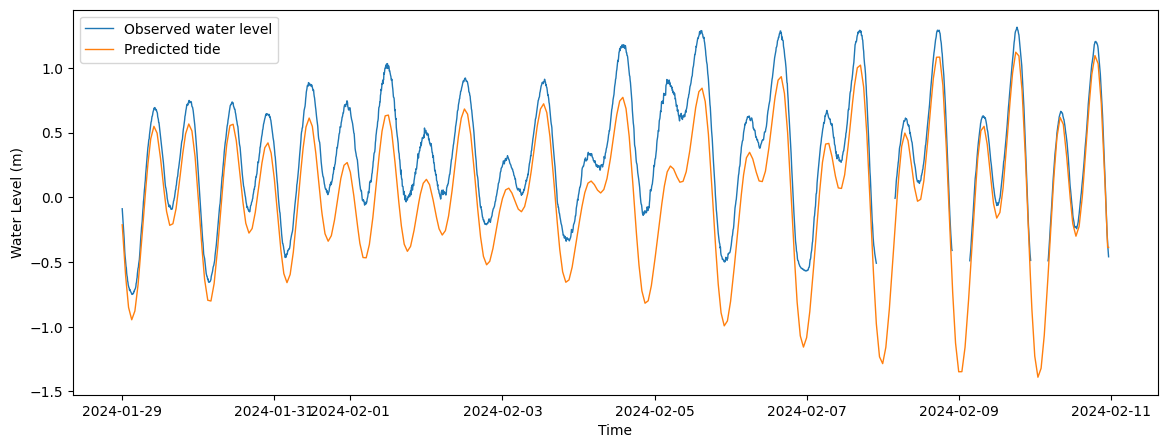

In [18]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df["water_level_m"], label="Observed water level", linewidth=1)
plt.plot(df.index, df["predicted_tide_m"], label="Predicted tide", linewidth=1)
# plt.title("Observed vs Predicted Water Levels – San Francisco")
plt.ylabel("Water Level (m)")
plt.xlabel("Time")
plt.legend()
plt.show()

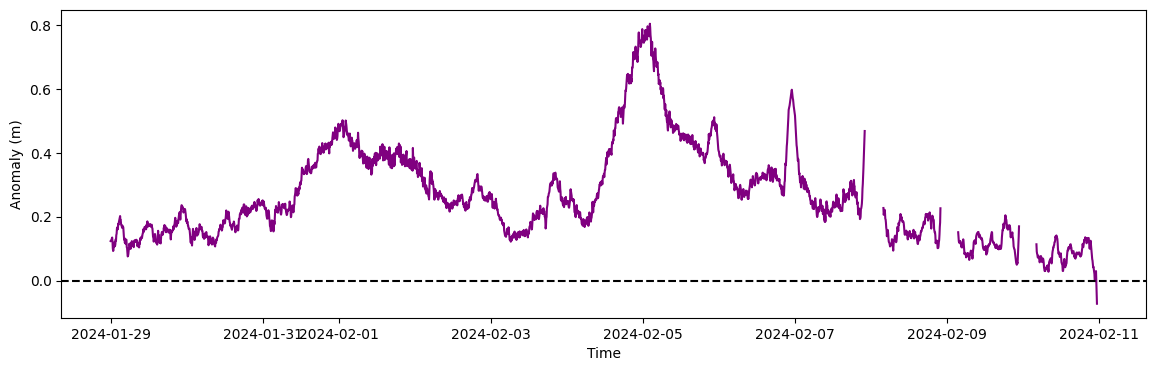

In [19]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["anomaly_m"], label="Anomaly", color="purple")
plt.axhline(0, linestyle="--", color="black")
# plt.title("Water Level Anomaly (Observed – Predicted)")
plt.ylabel("Anomaly (m)")
plt.xlabel("Time")
plt.show()

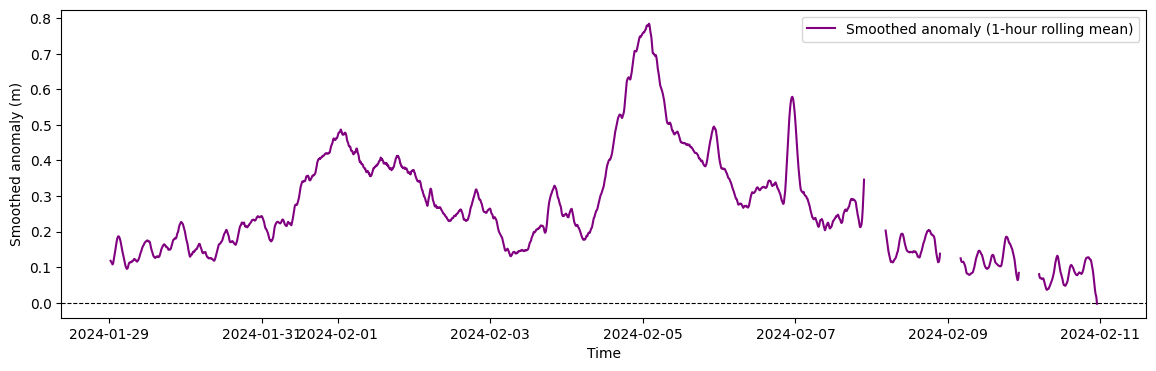

In [9]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["anomaly_smooth"],
         label="Smoothed anomaly (1-hour rolling mean)",
         color="purple")
plt.axhline(0, linestyle="--", color="black", linewidth=0.8)

# plt.title("Smoothed Water-Level Anomaly (Observed − Predicted Tide)")
plt.ylabel("Smoothed anomaly (m)")
plt.xlabel("Time")
plt.legend()
plt.show()

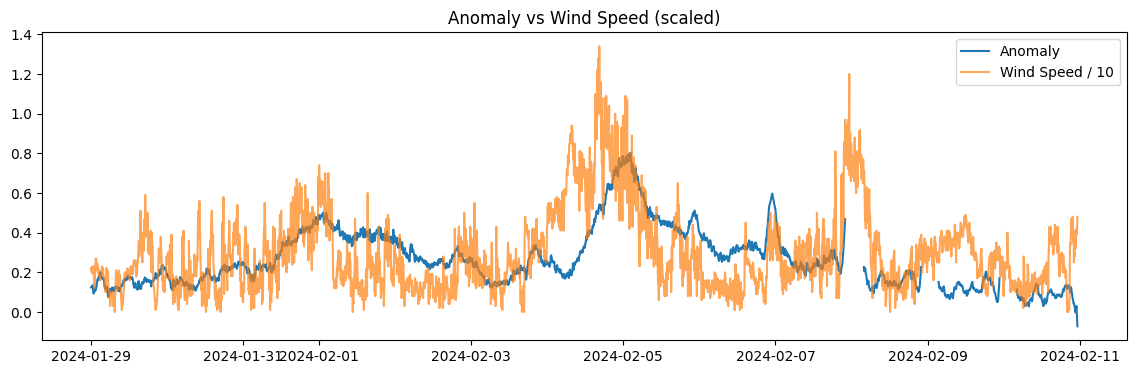

In [10]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["anomaly_m"], label="Anomaly")
plt.plot(df.index, df["wind_speed"]/10, label="Wind Speed / 10", alpha=0.7)  # scaled for viewing
plt.title("Anomaly vs Wind Speed (scaled)")
plt.legend()
plt.show()

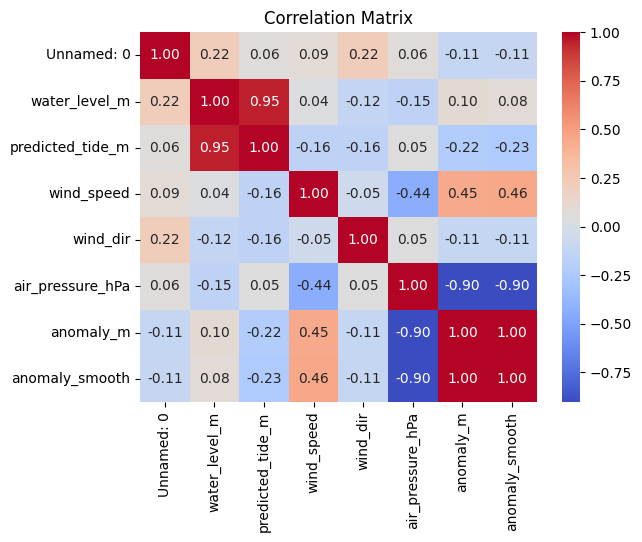

In [11]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## III. Methods

### 1. Control Chart
#### 1.1. Shewhart Control Chart

To set control limits using typical conditions, a historical baseline is built by pulling the same calendar window (Jan 29 to Feb 2) for multiple years:
`HIST_YEARS = [2020, 2021, 2022, 2023, 2024]`

The baseline distribution of anomaly_smooth is used to estimate `mu_hist` and `sigma_hist`, then:

`UCL = mu_hist + 3 * sigma_hist`

`LCL = mu_hist - 3 * sigma_hist`

An observation is flagged out of control if anomaly_smooth is outside [LCL, UCL].


In [ ]:
mu_hist = hist_base["anomaly_smooth"].mean()
sigma_hist = hist_base["anomaly_smooth"].std()

UCL = mu_hist + 3*sigma_hist
LCL = mu_hist - 3*sigma_hist

df["out_of_control"] = (df["anomaly_smooth"] > UCL) | (df["anomaly_smooth"] < LCL)

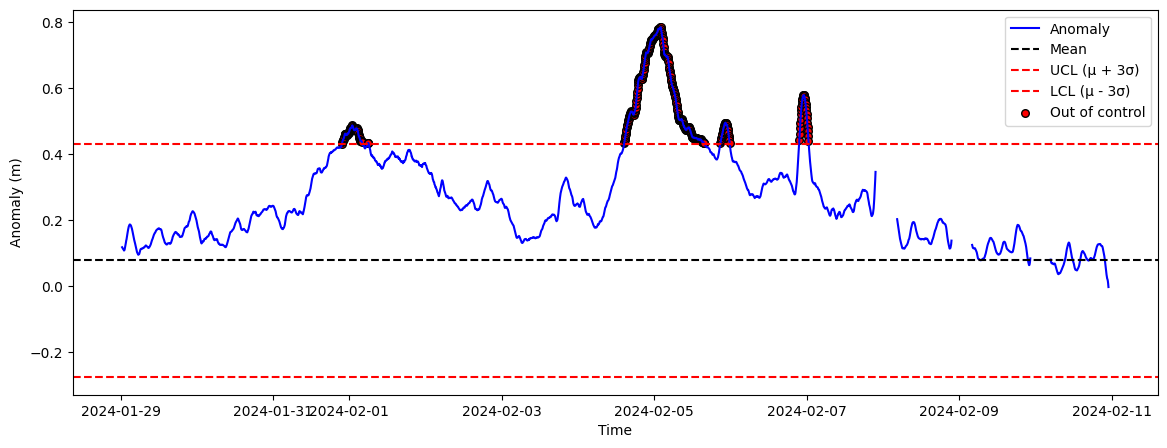

In [14]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df["anomaly_smooth"], label="Anomaly", color="blue")

plt.axhline(mu_hist, color="black", linestyle="--", label="Mean")
plt.axhline(UCL, color="red", linestyle="--", label="UCL (μ + 3σ)")
plt.axhline(LCL, color="red", linestyle="--", label="LCL (μ - 3σ)")

# Highlight out-of-control points
ooc = df[df["out_of_control"]]
plt.scatter(ooc.index, ooc["anomaly_smooth"], color="red", edgecolor="black", s=30, label="Out of control")

# plt.title("Control Chart for Water Level Anomaly")
plt.ylabel("Anomaly (m)")
plt.xlabel("Time")
plt.legend()
plt.show()

#### 1.2. CUSUM Chart
CUSUM is applied to `anomaly_smooth` to detect sustained shifts. `mu` and `sigma` are estimated from the `anomaly_smooth` series, and the reference value is set as:

`k = 0.25 * sigma`

CUSUM positive and negative statistics are updated sequentially.

In [15]:
mu = df["anomaly_smooth"].mean()
sigma = df["anomaly_smooth"].std()
k = 0.25 * sigma

x = df["anomaly_smooth"].fillna(mu) - mu
cpos = []
cneg = []
Sp = 0
Sn = 0

for xi in x:
    Sp = max(0, Sp + xi - k)
    Sn = max(0, Sn - xi - k)
    cpos.append(Sp)
    cneg.append(Sn)

df["CUSUM_pos"] = cpos
df["CUSUM_neg"] = cneg

In [ ]:
# baseline subset
base = df.loc["2024-02-01":"2024-02-02"].copy()

max_pos = base["CUSUM_pos"].max()
max_neg = (-base["CUSUM_neg"]).max() 

h_candidate = 1.25 * max(max_pos, max_neg) 
print("max baseline CUSUM+ :", max_pos)
print("max baseline |CUSUM-|:", max_neg)
print("Suggested h :", h_candidate)

max baseline CUSUM+ : 33.79611785786628
max baseline |CUSUM-|: -0.0
Suggested h : 42.24514732233285


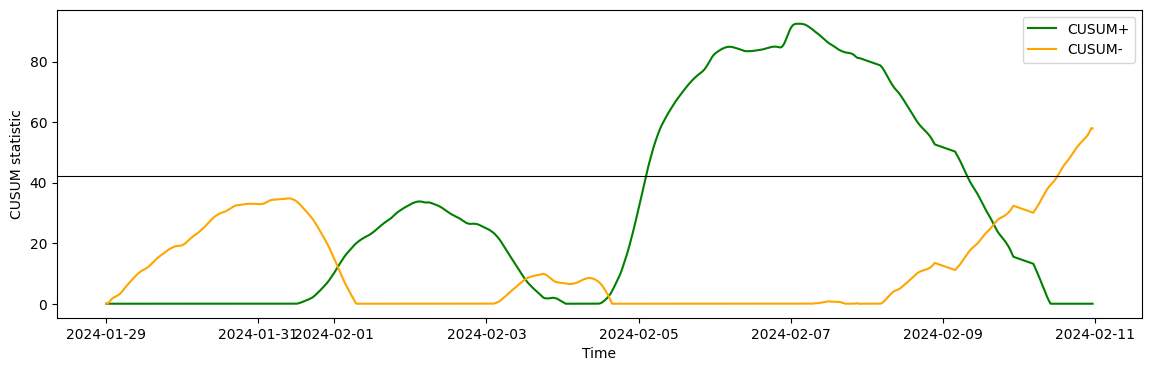

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df.index, df["CUSUM_pos"], label= "CUSUM+", color="green")
ax.plot(df.index, df["CUSUM_neg"], label= "CUSUM-", color="orange")
ax.axhline(h_candidate, color="black", linewidth=0.8)

# ax.set_title("CUSUM Chart for Water-Level Anomaly")
ax.set_ylabel("CUSUM statistic")
ax.set_xlabel("Time")
ax.legend()
plt.show()